In [6]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import datetime
import time
import pickle

## Motor Functions

### zero on the center, user enter the startng postion in degree

In [ ]:
c = moteus.Controller()

## Setup the Motor

User input: millimeters (because thats easier to think about than meters)
Motor motions: radians, radian/s, etc. (because thats is an SI type unit)
Actuator motions: millimeters (because thats an SI type unit)
Transforms: radians and millimeters because thats always pretty much they use

#### Run the code below to check the motor each Test

In [ ]:
n = input('Enter the number of loop')
d1,d2 = await stopping_acc_test(c,int(n))

## Let's Start the Test

### First, home the motor and save the initial position(radian,shows in degree)

In [ ]:
input('Press Enter to Start the Test')
ip = await motor_zero(c,stop_torque=.1,v=1)
print("Initial Starting Radian: ", ip*(2*math.pi))

### Run the CT scan for checking the postion error later.

### Once get the intial starting postion, run the testing function with the desired postion, and then run the CT scanner once motor moved.

In [ ]:
data_p_list = []
data_degree_list = []
data_time_list = []
i = 0

In [ ]:
ratio = 0.5040628051757813

In [ ]:
uds = int(input('Enter the desired postion in mm (0-127): '))
if i == 0:
    data_degree_list.append(uds)
    data_degree_list.append(uds)
    i += 1
else:
    data_degree_list.append(uds)

In [ ]:
currcent_p_list = []
if uds >= data_degree_list[-2]:
    currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=uds*ratio)
else:
    currcent_p_list,p_mm = await one_axis_backward(c,ip,user_desried=uds*ratio)
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

In [ ]:
p_mm = p_mm/ratio

### stop the motor

In [ ]:
await read_p()

### Saving the result

In [ ]:
with open('position.pkl', 'wb') as f:
    pickle.dump(data_p_list, f)
with open('degree.pkl', 'wb') as f:
    pickle.dump(data_degree_list, f)
with open('time.pkl', 'wb') as f:
    pickle.dump(data_time_list, f)

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

In [44]:
data = {}
s_num = 0

## Processing DICOM file

In [15]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

### Select the desired DICOM file

In [16]:
time = datetime.datetime.now()
time = time.strftime("%y/%m/%d %I:%M%p")

In [17]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()         
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.131772622000496481…

### Pick target marker postion

In [18]:
def func1(target_marker_select):
    global target_marker_name
    target_marker_name = target_marker_select

In [19]:
output = interact(func1, target_marker_select=['fixed_marker_crane', 'moving_marker_crane', 'moving_marker_1_DoF','fixed_marker_1_DoF'])

interactive(children=(Dropdown(description='target_marker_select', options=('fixed_marker_crane', 'moving_mark…

In [56]:
if target_marker_name == 'fixed_marker_crane':
    marker = np.load('./test_data/marker1.npy')
    R =  t3d.euler.euler2mat(np.pi/4+0.1, 0, -np.pi/6-0.2)@t3d.euler.euler2mat(0,0.6,0)# @ t3d.euler.euler2mat(0, np.pi/8, 0)
    marker = (R.T@marker.T).T
    crop_z = None
    #zero mean the marker since we place the rigid body at the mean here
    marker = marker - marker.mean(axis=0) - np.array([2,0,0])
if target_marker_name == 'moving_marker_crane':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'moving_marker_1_DoF':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'fixed_marker_1_DoF':
    marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
    R = np.eye(3)
    crop_z = [160,254]

In [57]:
print('Our marker: \n {}'.format(marker))

Our marker: 
 [[  0 -14   0]
 [  0  -6   0]
 [  0  16   0]
 [ 17   0   0]]


### Convert DICOM files

In [58]:
#convert scan to mesh for finding markers via thresholding
scan_file = series_file_names[selected_series]
convert_scan_to_mha(scan_file, crop_z = crop_z)
convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]


### Disaply DICOM file (Left and Right are the SAME)

origin: (-180.0, -180.0, -49.687372549019614)
size: (512, 512, 94)
spacing: (0.703125, 0.703125, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-180.0, -180.0, -49.687372549019614)
size: (512, 512, 94)
spacing: (0.703125, 0.703125, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>


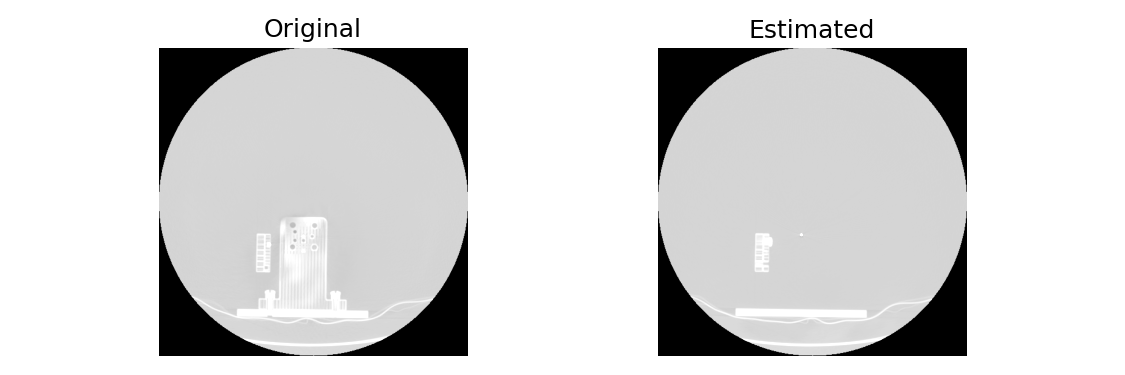

In [25]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

### Once the Imag above looks right, run the following code the find the neede error and transform

In [59]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)

print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=9
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 153.73it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters
[0 1 2 3 4 5 6 7]
marker centroid coordinates from design: [[  0 -14   0]
 [  0  -6   0]
 [  0  16   0]
 [ 17   0   0]]
found centroid coordinates: [-10.71  69.59 -52.46]


## Find marker

In [60]:
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ marker.T + tracked_t).T
error = permuted_centroids-transformed_marker

[12.94 13.83 10.21  9.11  8.77 15.61 11.12 11.79 12.54 12.65 13.78 14.77
  6.05  6.89  5.81 13.02 10.11 13.24 14.57 11.29 14.4  15.9   9.77 10.38
  9.55 13.9  17.22 19.25 12.69 14.6  13.61 14.25 16.26 15.75  7.72  8.86
  7.27 11.23 12.81  8.08 11.97 13.7   7.94 10.13  8.41 10.59 14.55 15.41
 10.29 10.85 11.18 11.6  12.38 13.23  4.86  0.09 10.37 12.78  7.84  9.79
 12.77  8.9  10.99 13.96  9.15 12.01 13.78 17.56 13.11 14.72]
Everything looks good!
the final error is:  0.09330904646798563


## Visualize Marker

In [ ]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
visualization_list1 = copy.deepcopy(visualization_list2)
o3d.visualization.draw_geometries(visualization_list2)

### Create Marker object

In [61]:
append_value(data, "scan"+str(s_num), Marker(time,target_marker_name,selected_series,marker,t2T(tracked_R, tracked_t/1000),np.linalg.norm(error)**0.5))

## Visualize tracked markers and full scan w/ low threshold

In [ ]:
convert_scan_to_mha(scan_file)
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.obj', threshold_value = -400)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.obj').paint_uniform_color([0.0, 0.0, 0.8]).compute_vertex_normals()
o3d.visualization.draw_geometries(visualization_list2+visualization_list1+[temp_full_mesh])

# Run for the other move/fix marker than run the following code

In [ ]:
append_value(data, "scan"+str(s_num),Robot(time,ratio,p_mm,uds))
s_num += 1

In [62]:
data

{'scan0': [Marker(moving_marker_1_DoF:22/08/10 02:58PM),
  Marker(fixed_marker_1_DoF:22/08/10 02:58PM)]}

In [63]:
# save data for later use
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Load the data back

In [64]:
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)
print(data_load['scan0'])

[Marker(moving_marker_1_DoF:22/08/10 02:58PM), Marker(fixed_marker_1_DoF:22/08/10 02:58PM)]


## forward kinematics

In [34]:
from spatialmath import *
from roboticstoolbox import ET as E

In [66]:
Tm = SE3(data_load['scan0'][0].T)
Tfix = SE3(data_load['scan0'][1].T)

<IPython.core.display.Javascript object>


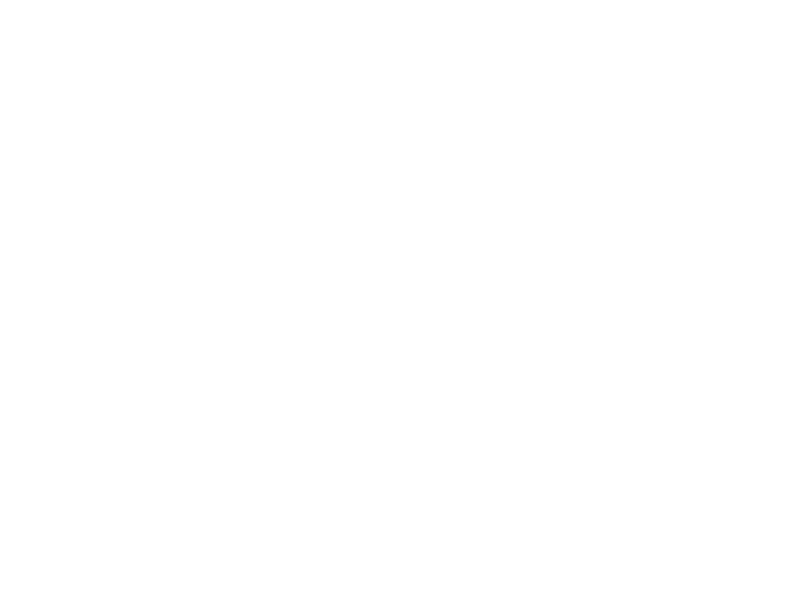

<IPython.core.display.Javascript object>


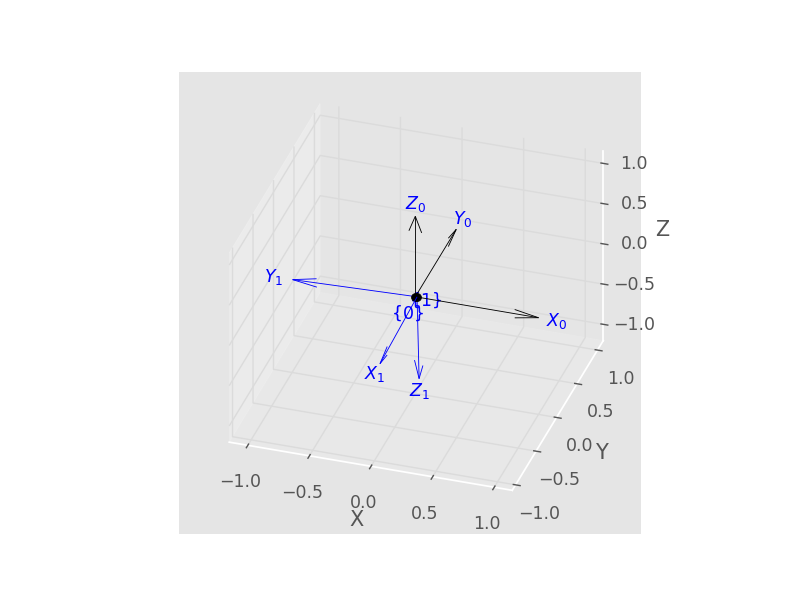

In [53]:
plt.figure() # create a new figure
SE3().plot(frame='0', color='black')
Tm.plot(frame='1')

In [2]:
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Ry(90, 'deg')*E.Rz(-90, 'deg')*

In [71]:
Tfixi = Tfix.inv()
Tfk2 = Tfixi*Tfk
Tfk = SE3(e.eval([1]))

<IPython.core.display.Javascript object>


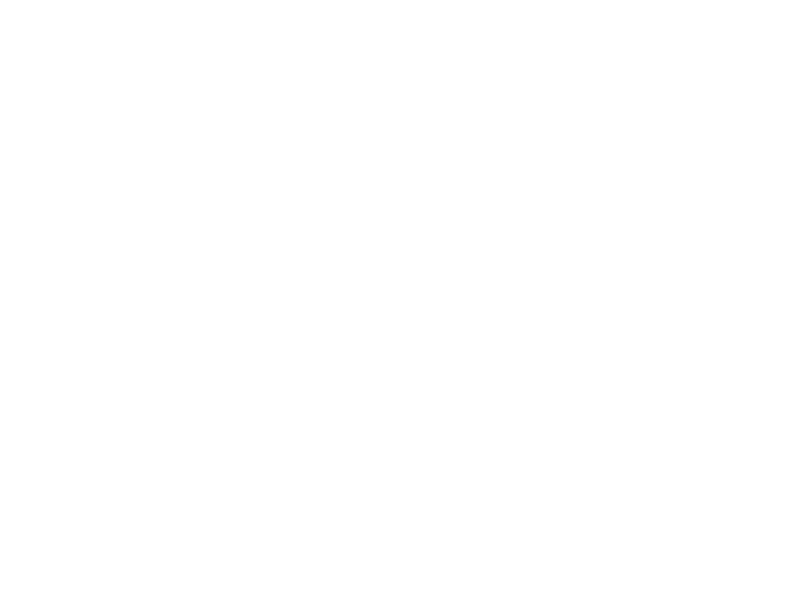

<IPython.core.display.Javascript object>


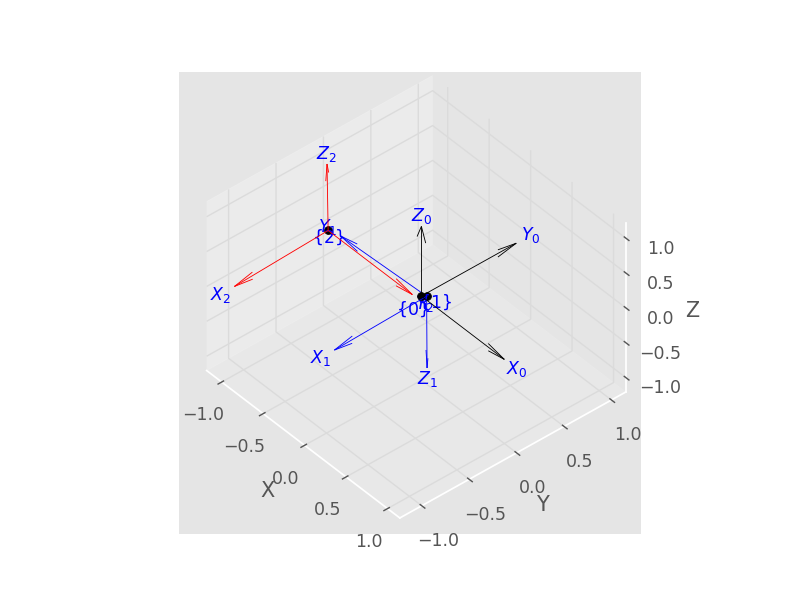

In [75]:
plt.figure() # create a new figure
SE3().plot(frame='0', color='black')
Tm.plot(frame='1',color='blue')
Tfk2.plot(frame='2',color='red')